# Check granule's STARE cover with its observation locations



In [1]:
import sys
import os

import pystare
import geopandas
import starepandas
import shapely
import numpy

from netCDF4 import Dataset
from pyhdf.SD import SD, SDC

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

In [10]:
import pystareplotlib
from pystareplotlib.hello_plot import hello_plot

In [14]:
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [33]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# Some helper functions for plotting & printing.

def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr(verbose = True):
    sys.stderr.close()
    if verbose:
        with open('stderr.out') as f:
            count = sum(1 for _ in f)
        if count > 0:
            print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,alpha=1
        ,lw=1
        ,verbose = True
        ,title = None
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = pystare.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,alpha=alpha,transform=plot_options['transform'],lw=lw)
        restore_stderr(verbose=verbose)
    
    if title is not None:
        plt.title(title)
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
# proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson()
proj        = ccrs.Mollweide()
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

set_global   = True

In [3]:
class mod05_data(object):
    "Provides an interface to MOD05 data of interest from the granule and its sidecar."
    def __init__(self,file):
    
        try:
            print('loading ',file)
            self.file=file
            ds = starepandas.SD_wrapper(self.file)
            self.lat_5km = starepandas.with_hdf4_get(ds,'Latitude');
            self.lon_5km = starepandas.with_hdf4_get(ds,'Longitude')
            self.img_wvir = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared')
            self.img_wvir,self.attrs = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
            self.img_wvir[numpy.where(self.img_wvir == self.attrs['_FillValue'])] = 0 # Or use a mask
            self.img_wvir = (self.img_wvir-self.attrs['add_offset'])*self.attrs['scale_factor']
            ds.end()
        except:
            print('%s not found. Skipping.'%(file,))
            pass

        try:
            sidecar_file='.'.join(file.split('.')[0:-1])+'_stare.nc'
            print('loading ',sidecar_file)
            self.sidecar_file=sidecar_file
            ds = starepandas.nc4_Dataset_wrapper(sidecar_file)
            self.index2d = ds['STARE_index_5km'][:,:].astype(numpy.int64)
            self.cover   = ds['STARE_cover_5km'][:].astype(numpy.int64)
            self.lat2d   = ds['Latitude_5km'][:,:]
            self.lon2d   = ds['Longitude_5km'][:,:]
            ds.close()
        except Exception as e:
            # print('%s not found. Skipping.'%(sidecar_file,))
            print(e)
            raise e
            # pass
            
        return

In [4]:
dirname  = '/Users/mrilee/Remote/Dropbox/data/MODAPS/MOD05/2019/tmp/'
filename = 'MOD05_L2.A2019336.2355.061.2019337072028.hdf'

In [20]:
dirname  = '/Users/mrilee/git/STAREmaster-build/test/data/'
filename = 'MOD05_L2.A2005349.2125.061.2017294065400.hdf'

In [21]:
ds = mod05_data(os.path.join(dirname,filename))

loading  /Users/mrilee/git/STAREmaster-build/test/data/MOD05_L2.A2005349.2125.061.2017294065400.hdf
loading  /Users/mrilee/git/STAREmaster-build/test/data/MOD05_L2.A2005349.2125.061.2017294065400_stare.nc


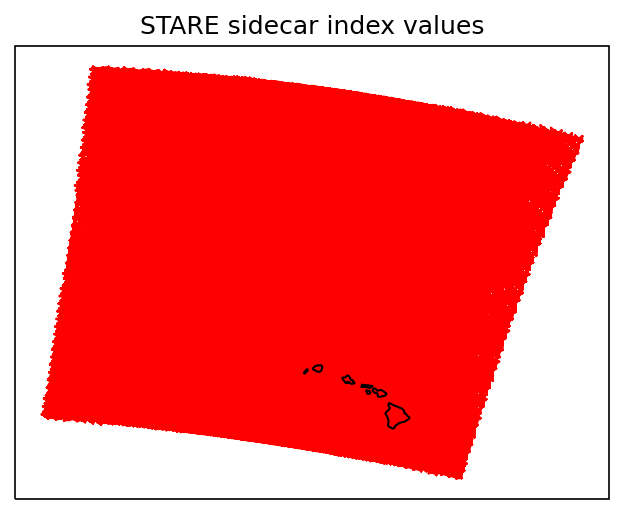

In [22]:
hello_plot(ds.index2d.flatten(),color='r',title='STARE sidecar index values')

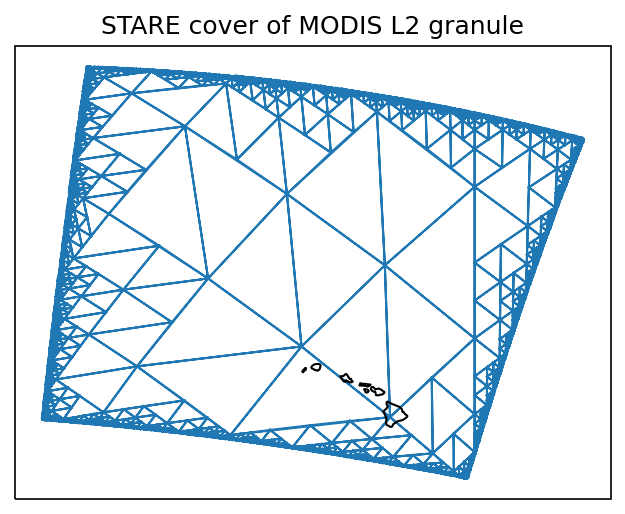

In [23]:
hello_plot(ds.cover,title='STARE cover of MODIS L2 granule')

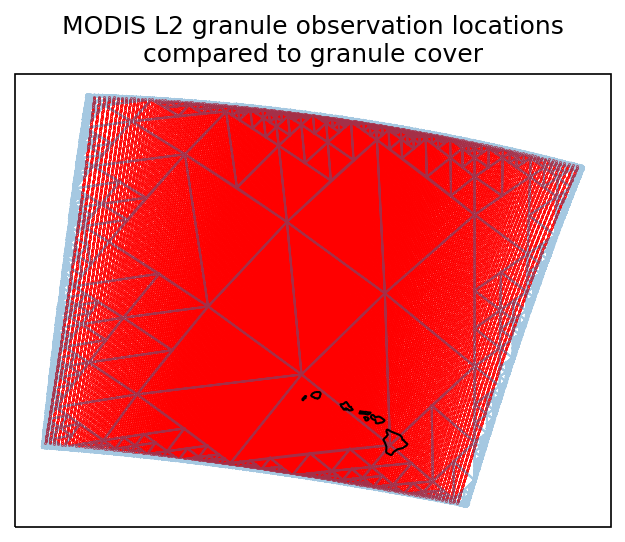

In [24]:
figax = hello_plot(ds.cover,show=False,alpha=0.4,set_global=False)
plt.scatter(ds.lon_5km,ds.lat_5km,s=0.1,color='r')
plt.title('MODIS L2 granule observation locations\ncompared to granule cover')
plt.show()